# Main

This will be the notebook to perform the steps required to generate the topographical hexagons I desire. I will import the functions written in the other files and combine them in such a way as to create the hexagons I desire.

### Initialisation
This code will set up the environment required to produce the plots I would like. As such, I'll be importing my python scripts and any other required modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rc('image', cmap='terrain')


import loadData as LD
import CoordinateTransform as CT
import Hexagon as Hexagon
import HexGrid as HexGrid

### Loading data
I will load in the data for both of the SRTM datasets and concatenate them into a single matrix.
From there, I will downsample the matrix twice until it is 1500 * 3000

In [2]:
seaVal = -2

D1,m1 = LD.load_asc_format('data\\srtm_35_04\\','srtm_35_04.asc',seaVal)
D2,m2 = LD.load_asc_format('data\\srtm_36_04\\','srtm_36_04.asc',seaVal)

D_combined = np.hstack((D1,D2))

In [ ]:
plt.figure(figsize = (10,4))

plt.subplot(1,4,1)
plt.imshow(D1,origin='lower',interpolation='bilinear')

plt.subplot(1,4,2)
plt.imshow(D2,origin='lower',interpolation='bilinear')

plt.subplot(1,2,2)
plt.imshow(D_combined,origin='lower',interpolation='bilinear')

plt.show()

### Downsampling and surface plotting

I will downsample the data to be able to create a surface plot. I will then be able to apply scaling functions to the downsampled data and see how they affect the model.

In [ ]:
# performing two downsamples on the matrix

newD,__ = LD.downsample_minimum(D_combined)
newD,__ = LD.downsample_minimum(newD)

In [ ]:
%matplotlib widget

fig = plt.figure(figsize = (8,4))
ax1 = fig.add_subplot(121, projection='3d')
x,y = range(np.size(newD,1)), range(np.size(newD,0))
X,Y = np.meshgrid(x,y)
ax1.plot_surface(X,Y,newD,rcount=100,ccount=100)

################################################################
idf = lambda x: x # identity function, for copying newD
nnewD = idf(newD)

#rescaling the heightmap by a function to exagerate lower elevations more
#k = 10
#w = lambda x: np.log(x)*k
#w = lambda x: np.sqrt(x)*k
#newD[newD > 0] = w(newD[newD > 0])

#w = lambda x: x/20
#newD[newD > 0] = w(newD[newD > 0])
w = lambda x: np.sqrt(x) #if x>0 else x
nnewD[nnewD > 0] = w(nnewD[nnewD > 0])

#################################################################

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X,Y,nnewD,rcount=100,ccount=100)

ax1.azim = 121
ax1.elev = 25
ax1.set_box_aspect((4,2,2))
ax2.set_zlim3d(seaVal-2)
ax2.azim = 121
ax2.elev = 25
ax2.set_box_aspect((4,2,2))
ax2.set_zlim3d(seaVal-2)
plt.show()

### Hexagons and culling

I will use the Hexagon and CoordinateTransform modules to cull our map in the shape of a hexagon with arbitrary centre and rotation.

In [ ]:
# Coordinate transform
'''
# start by creating the coordinate transform based on the metadata from the SRTM data.
newD,lcd = LD.downsample_minimum(D_combined)
#newM1 = m1
#newM1[2] = newM1[2] * lcd
ref1Img = [0,0]
ref1Coords = [m1[0],m1[1]]
ref2Img = [6000,3000]
ref2Coords = [0,45]
Transform = CT.CoordinateTransform(ref1Img,ref1Coords,None,ref2Img,ref2Coords)

'''

In [ ]:
cullValue = -20

newD,lcd = LD.downsample_minimum(D_combined)
print(lcd)
newM = m1.copy()
newM[2] = newM[2] * lcd
Transform = CT.CoordinateTransform(metadata=newM)


# going to get the coordinate reference for Oviedo
#coords = [-5.849259, 42.361374] #long,lat ## Oviedo
#coords = [-2.349515,43.091012] #long,lat  ## basque country
#coords = [-5,45]
coords = np.array([-1.974412, 43.515345]).reshape((2,1)) # roughly the first point I want


img = Transform.coords2Img(coords)
print('Oviedo_img: {}'.format(img))

# create the hexagon of 200 pixels radius, centered on Oviedo
H = Hexagon.Hexagon(900,4,img)

# create all the points in image space
x = range(0,np.size(newD,1))
y = range(0,np.size(newD,0))
X,Y = np.meshgrid(x,y)
print(np.shape(X))

cullMask = H.outsideHexagon_grid(X,Y)

plt.figure(figsize = (40,20))

plt.subplot(1,4,1)
plt.imshow(newD,origin='lower',interpolation='bilinear')


newD[cullMask] = cullValue

plt.subplot(1,4,2)
plt.imshow(newD,origin='lower',interpolation='bilinear')

H2 = H.createAdjacentHexagon(3)
newCullMask = H2.outsideHexagon_grid(X,Y)
newD,__ = LD.downsample_minimum(D_combined)
newD[newCullMask] = cullValue
plt.subplot(1,4,3)
plt.imshow(newD,origin='lower',interpolation='bilinear')

newD,__ = LD.downsample_minimum(D_combined)
newD[np.logical_and(cullMask,newCullMask)] = cullValue
plt.subplot(1,4,4)
plt.imshow(newD,origin='lower',interpolation='bilinear')


## Bringing it all together

In this section, I'll try to combine the culling with hexagons with loading in the locatio data to plot it all on the map and demonstrate that it can be done together.

In [ ]:
# Start by creating the coordinate transform object, and the initial newD image matrix
newD,lcd = LD.downsample_minimum(D_combined)
newM = m1.copy()
newM[2] = newM[2] * lcd
Transform = CT.CoordinateTransform(metadata=newM)

In [ ]:
# then extract the path coordinates from the journeyCoords.txt file, and convert them into image space coordinates.
pathCoords,pathNames = LD.load_coordinate_list('data\\','journeyCoords.txt')

pathImgCoords = Transform.coords2Img(pathCoords)
print(pathImgCoords)

In [ ]:
#This will cull the newD image so that its only represented by the hexagons.
cullValue = -20


# going to get the coordinate reference for Oviedo
#coords = [-5.849259, 42.361374] #long,lat ## Oviedo
#coords = [-2.349515,43.091012] #long,lat  ## basque country
#coords = [-5,45] # test
coords = np.array([-1.974412, 43.215345]).reshape((2,1)) # roughly the first point I want


img = Transform.coords2Img(coords)
# create the hexagon of 200 pixels radius, centered on coords
H = Hexagon.Hexagon(550,3,img)

# create all the points in image space
x = range(0,np.size(newD,1))
y = range(0,np.size(newD,0))
X,Y = np.meshgrid(x,y)
print(np.shape(X))

cullMask = H.outsideHexagon_grid(X,Y)
#mask = cullMask.copy()

for j in range(4): # create 4 additional hexagons to the left
    print('j: {}'.format(j))
    H = H.createAdjacentHexagon(3)
    cullMask = np.logical_and(cullMask,H.outsideHexagon_grid(X,Y))
    
#newD[cullMask] = cullValue

In [ ]:
# plotting the results of the culling and journey coordinates
plt.figure(figsize = (40,20))

plt.hold = True

#--------------------------------------------------LEFT IMAGE---------------------------------------------------
plt.subplot(1,2,1)
plt.imshow(newD,origin='lower',interpolation='bilinear')

plt.scatter(pathImgCoords[0,:],pathImgCoords[1,:],s=40,c='r')


#-------------------------------------------------RIGHT IMAGE---------------------------------------------------
plt.subplot(1,2,2)
newD[cullMask] = cullValue

plt.imshow(newD,origin='lower',interpolation='bilinear')

plt.show()

## Using the HexGrid to accomplish the job

In [3]:
newD,lcd = LD.downsample_minimum(D_combined)
newM = m1.copy()
newM[2] = newM[2] * lcd
Transform = CT.CoordinateTransform(metadata=newM)


coords = np.array([-1.974412, 43.215345]).reshape((2,1)) # roughly the first point I want
img = Transform.coords2Img(coords)

# create the hexagon centered on coords
targetH = Hexagon.Hexagon(550,3,img)

# create all the points in image space
x = range(0,np.size(newD,1))
y = range(0,np.size(newD,0))
X,Y = np.meshgrid(x,y)
print(np.shape(X))



v,f = HexGrid.layerAlgorithm(targetH,50)

# showing the hexagons work themselves
#fig = plt.figure(figsize=(40,20))
#ax = fig.add_subplot(121)
#ax.scatter(v[0,:],v[1,:])


HexD = HexGrid.interpolateGrids(v,X,Y,newD)

#ax = fig.add_subplot(111)
#ax.contourf(v[0,:],v[1,:],HexD)

newD created, size is (3000,6000)
(3000, 6000)
xUnder shape: (7651,)
yUnder shape: (7651,)
D_xUyU shape: (7651,)
weights shape: (4, 7651)


(7651,)


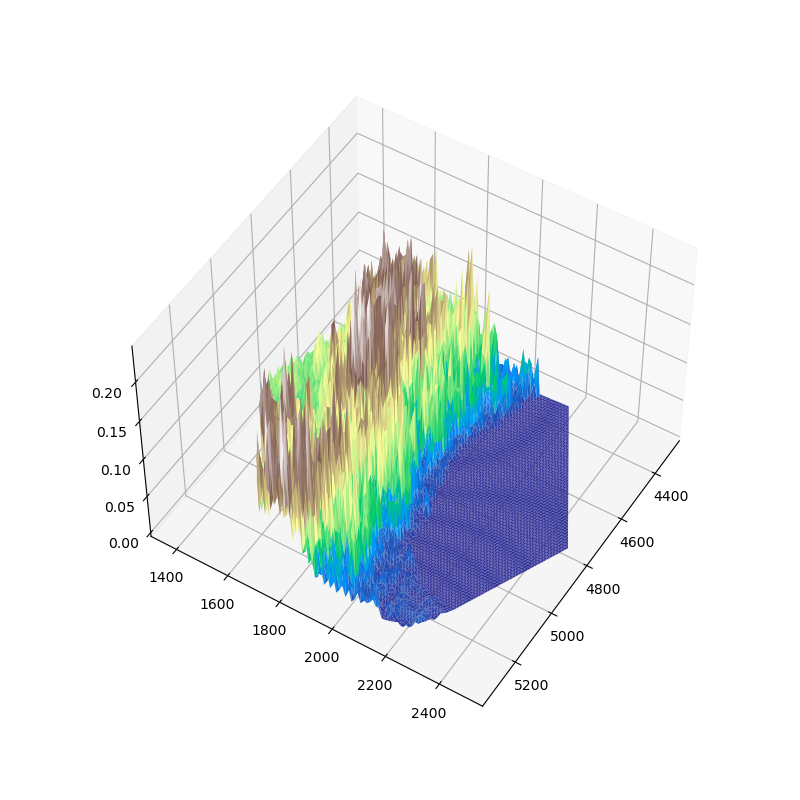

In [4]:
%matplotlib widget
print(HexD.shape)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(v[0,:], v[1,:], HexD, triangles=f,cmap='terrain')
ax.view_init(50,32)

### Further visualisation efforts

Here, I present my attempts at scaling the heightmap to make it better for printing, and to create a 3d plot to show it off.

In [ ]:
%matplotlib widget
# 3d plot of newD before any scaling is applied
scaleD = newD.copy()
scaleD = scaleD[1070:2740,240:5680]
scaleX = X[1070:2740,240:5680]
scaleY = Y[1070:2740,240:5680]

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(scaleX,scaleY,scaleD,rcount=60,ccount=60,cmap='terrain',antialiased=False)
ax.view_init(50,32)
ax.set_box_aspect((np.ptp(scaleX), np.ptp(scaleY),np.ptp(scaleD)))

In [ ]:
scaleD = newD.copy()
'''
w = lambda x: x#np.sign(x)*np.log(np.abs(x)+1)
scaleD = w(scaleD)
'''

reductionFactor = 0.01
scaleD[scaleD > cullValue] *= reductionFactor
scaleD[scaleD == cullValue] = -6
scaleD[scaleD == seaVal] = -1


scaleD = scaleD[1070:2740,240:5680]
scaleX = X[1070:2740,240:5680]
scaleY = Y[1070:2740,240:5680]

In [ ]:
%matplotlib widget

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(scaleX,scaleY,scaleD,rcount=100,ccount=100,cmap='terrain',antialiased=False)
ax.view_init(50,32)
ax.set_box_aspect((np.ptp(scaleX), np.ptp(scaleY),np.ptp(newD)))